# 4.4.5 Challenge: Build your own NLP model
For this challenge, you will need to choose a corpus of data from nltk or another source that includes categories you can predict and create an analysis pipeline that includes the following steps:

1. Data cleaning / processing / language parsing
2. Create features using two different NLP methods: For example, BoW vs tf-idf.
3. Use the features to fit supervised learning models for each feature set to predict the category outcomes.
4. Assess your models using cross-validation and determine whether one model performed better.
5. Pick one of the models and try to increase accuracy by at least 5 percentage points.

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import json
import re
import nltk
from nltk.corpus import inaugural
from collections import Counter
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

nltk.download('inaugural')

[nltk_data] Downloading package inaugural to /Users/user/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!


True

In [6]:
inaugural.fileids()

['1789-Washington.txt',
 '1793-Washington.txt',
 '1797-Adams.txt',
 '1801-Jefferson.txt',
 '1805-Jefferson.txt',
 '1809-Madison.txt',
 '1813-Madison.txt',
 '1817-Monroe.txt',
 '1821-Monroe.txt',
 '1825-Adams.txt',
 '1829-Jackson.txt',
 '1833-Jackson.txt',
 '1837-VanBuren.txt',
 '1841-Harrison.txt',
 '1845-Polk.txt',
 '1849-Taylor.txt',
 '1853-Pierce.txt',
 '1857-Buchanan.txt',
 '1861-Lincoln.txt',
 '1865-Lincoln.txt',
 '1869-Grant.txt',
 '1873-Grant.txt',
 '1877-Hayes.txt',
 '1881-Garfield.txt',
 '1885-Cleveland.txt',
 '1889-Harrison.txt',
 '1893-Cleveland.txt',
 '1897-McKinley.txt',
 '1901-McKinley.txt',
 '1905-Roosevelt.txt',
 '1909-Taft.txt',
 '1913-Wilson.txt',
 '1917-Wilson.txt',
 '1921-Harding.txt',
 '1925-Coolidge.txt',
 '1929-Hoover.txt',
 '1933-Roosevelt.txt',
 '1937-Roosevelt.txt',
 '1941-Roosevelt.txt',
 '1945-Roosevelt.txt',
 '1949-Truman.txt',
 '1953-Eisenhower.txt',
 '1957-Eisenhower.txt',
 '1961-Kennedy.txt',
 '1965-Johnson.txt',
 '1969-Nixon.txt',
 '1973-Nixon.txt',
 '1

In [48]:
roosevelt33 = inaugural.raw('1933-Roosevelt.txt')
roosevelt37 = inaugural.raw('1937-Roosevelt.txt')
roosevelt39 = inaugural.raw('1941-Roosevelt.txt')
roosevelt45 = inaugural.raw('1945-Roosevelt.txt') 
truman = inaugural.raw('1949-Truman.txt')
eisenhower53 = inaugural.raw('1953-Eisenhower.txt')
eisenhower57 = inaugural.raw('1957-Eisenhower.txt')
kennedy = inaugural.raw('1961-Kennedy.txt')
johnson = inaugural.raw('1965-Johnson.txt')
nixon69 = inaugural.raw('1969-Nixon.txt')
nixon73 = inaugural.raw('1973-Nixon.txt')
carter = inaugural.raw('1977-Carter.txt')
reagan81 = inaugural.raw('1981-Reagan.txt')
reagan85 = inaugural.raw('1985-Reagan.txt')
bush_sr = inaugural.raw('1989-Bush.txt')
clinton93 = inaugural.raw('1993-Clinton.txt')
clinton97 = inaugural.raw('1997-Clinton.txt')
bush_jr01 = inaugural.raw('2001-Bush.txt')
bush_jr05 = inaugural.raw('2005-Bush.txt')
obama09 = inaugural.raw('2009-Obama.txt')



In [49]:
address

["I am certain that my fellow Americans expect that on my induction into the Presidency I will address them with a candor and a decision which the present situation of our Nation impels. This is preeminently the time to speak the truth, the whole truth, frankly and boldly. Nor need we shrink from honestly facing conditions in our country today. This great Nation will endure as it has endured, will revive and will prosper. So, first of all, let me assert my firm belief that the only thing we have to fear is fear itself -- nameless, unreasoning, unjustified terror which paralyzes needed efforts to convert retreat into advance. In every dark hour of our national life a leadership of frankness and vigor has met with that understanding and support of the people themselves which is essential to victory. I am convinced that you will again give that support to leadership in these critical days.\n\nIn such a spirit on my part and on yours we face our common difficulties. They concern, thank God

In [63]:
def clean_text(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub('--',' ',text)
    text = re.sub('/\\n/g', "", text)
    text = ' '.join(text.split())
    return text

#for president in address:
    #president = clean_text(president)

roosevelt33 = clean_text(roosevelt33)
roosevelt37 = clean_text(roosevelt37)
roosevelt39 = clean_text(roosevelt39)
roosevelt45 = clean_text(roosevelt45)
truman = clean_text(truman)
eisenhower53 = clean_text(eisenhower53)
eisenhower57 = clean_text(eisenhower57)
kennedy = clean_text(kennedy)
johnson = clean_text(johnson)
nixon69 = clean_text(nixon69)
nixon73 = clean_text(nixon73)
carter = clean_text(carter)
reagan81 = clean_text(reagan81)
reagan85 = clean_text(reagan85)
bush_sr = clean_text(bush_sr)
clinton93 = clean_text(clinton93)
clinton97 = clean_text(clinton97)
bush_jr01 = clean_text(bush_jr01)
bush_jr05 = clean_text(bush_jr05)
obama = clean_text(obama09)




In [91]:
addresses = roosevelt33 + roosevelt37 + roosevelt39 + roosevelt45 + truman + eisenhower53 + eisenhower57 + kennedy + johnson + nixon69 + nixon73 + carter + reagan81 + reagan85 + bush_sr + clinton93 + clinton97 + bush_jr01 + bush_jr05 + obama

addresses


'I am certain that my fellow Americans expect that on my induction into the Presidency I will address them with a candor and a decision which the present situation of our Nation impels. This is preeminently the time to speak the truth, the whole truth, frankly and boldly. Nor need we shrink from honestly facing conditions in our country today. This great Nation will endure as it has endured, will revive and will prosper. So, first of all, let me assert my firm belief that the only thing we have to fear is fear itself nameless, unreasoning, unjustified terror which paralyzes needed efforts to convert retreat into advance. In every dark hour of our national life a leadership of frankness and vigor has met with that understanding and support of the people themselves which is essential to victory. I am convinced that you will again give that support to leadership in these critical days. In such a spirit on my part and on yours we face our common difficulties. They concern, thank God, only 

In [64]:
roosevelt = roosevelt33 + roosevelt37 + roosevelt39 + roosevelt45
eisenhower = eisenhower53 + eisenhower57
nixon = nixon69 + nixon73
reagan = reagan81 + reagan85
clinton = clinton93 + clinton97
bush_jr = bush_jr01 + bush_jr05

In [67]:
nlp = spacy.load('en')
roosevelt_doc = nlp(roosevelt) 
truman_doc = nlp(truman)
eisenhower_doc = nlp(eisenhower)
kennedy_doc = nlp(kennedy)
johnson_doc = nlp(johnson)
nixon_doc = nlp(nixon)
carter_doc = nlp(carter)
reagan_doc = nlp(reagan)
bush_sr_doc = nlp(bush_sr)
clinton_doc = nlp(clinton)
bush_jr_doc = nlp(bush_jr)
obama_doc = nlp(obama)

In [69]:
# Group into sentences.

roosevelt_sents = [[sent, "Democrat"] for sent in roosevelt_doc.sents]
truman_sents = [[sent, "Democrat"] for sent in truman_doc.sents]
eisenhower_sents = [[sent, "Republican"] for sent in eisenhower_doc.sents]
kennedy_sents = [[sent, "Democrat"] for sent in kennedy_doc.sents]
johnson_sents = [[sent, "Democrat"] for sent in johnson_doc.sents]
nixon_sents = [[sent, "Republican"] for sent in nixon_doc.sents]
carter_sents = [[sent, "Democrat"] for sent in carter_doc.sents]
reagan_sents = [[sent, "Republican"] for sent in reagan_doc.sents]
bush_sr_sents = [[sent, "Republican"] for sent in bush_sr_doc.sents]
clinton_sents = [[sent, "Democrat"] for sent in clinton_doc.sents]
bush_jr_sents = [[sent, "Republican"] for sent in bush_jr_doc.sents]
obama_sents = [[sent, "Democrat"] for sent in obama_doc.sents]


# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(roosevelt_sents + 
        truman_sents +
        eisenhower_sents +
        kennedy_sents +
        johnson_sents +
        nixon_sents +
        carter_sents +
        reagan_sents +
        bush_sr_sents +
        clinton_sents +
        bush_jr_sents +
        obama_sents)
sentences.head()

,0,1
0,"(I, am, certain, that, my, fellow, Americans, ...",Democrat
1,"(This, is, preeminently, the, time, to, speak,...",Democrat
2,"(Nor, need, we, shrink, from, honestly, facing...",Democrat
3,"(This, great, Nation, will, endure, as, it, ha...",Democrat
4,"(So, ,, first, of, all, ,, let, me, assert, my...",Democrat


In [100]:
roosevelt_sents

[[I am certain that my fellow Americans expect that on my induction into the Presidency I will address them with a candor and a decision which the present situation of our Nation impels.,
  'Democrat'],
 [This is preeminently the time to speak the truth, the whole truth, frankly and boldly.,
  'Democrat'],
 [Nor need we shrink from honestly facing conditions in our country today.,
  'Democrat'],
 [This great Nation will endure as it has endured, will revive and will prosper.,
  'Democrat'],
 [So, first of all, let me assert my firm belief that the only thing we have to fear is fear itself nameless, unreasoning, unjustified terror which paralyzes needed efforts to convert retreat into advance.,
  'Democrat'],
 [In every dark hour of our national life a leadership of frankness and vigor has met with that understanding and support of the people themselves which is essential to victory.,
  'Democrat'],
 [I am convinced that you will again give that support to leadership in these critical d

In [70]:
print(len(sentences))

1941


In [72]:
def bag_of_words(text):
    allwords = [token.lemma_
               for token in text
               if not token.is_punct
               and not token.is_stop]
    return [item[0] for item in Counter(allwords).most_common(2000)]

def bow_features(sentences, common_words):
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_party'] = sentences[1]
    df.loc[:,common_words] = 0
    
    for i, sentence in enumerate(df['text_sentence']):
        words = [token.lemma_ 
                for token in sentence
                if (
                    not token.is_punct
                    and not token.is_stop
                    and token.lemma_ in common_words
                )]
        for word in words:
            df.loc[i, word] += 1
        if i%100 == 0:
            print('Processing row {}'.format(i))
    return df

In [73]:
roosevelt_words = bag_of_words(roosevelt_doc)
truman_words = bag_of_words(truman_doc)
eisenhower_words = bag_of_words(eisenhower_doc)
kennedy_words = bag_of_words(kennedy_doc)
johnson_words = bag_of_words(johnson_doc)
nixon_words = bag_of_words(nixon_doc)
carter_words = bag_of_words(carter_doc)
reagan_words = bag_of_words(reagan_doc)
bush_sr_words = bag_of_words(bush_sr_doc)
clinton_words = bag_of_words(clinton_doc)
bush_jr_words = bag_of_words(bush_jr_doc)
obama_words = bag_of_words(obama_doc)

common_words = set(roosevelt_words +
        truman_words + 
        eisenhower_words + 
        kennedy_words +
        johnson_words +
        nixon_words +
        carter_words +
        reagan_words +
        bush_sr_words +
        clinton_words +
        bush_jr_words +
        obama_words)

In [75]:
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 100
Processing row 200
Processing row 300
Processing row 400
Processing row 500
Processing row 600
Processing row 700
Processing row 800
Processing row 900
Processing row 1000
Processing row 1100
Processing row 1200
Processing row 1300
Processing row 1400
Processing row 1500
Processing row 1600
Processing row 1700
Processing row 1800
Processing row 1900


,birthday,Bernardin,wholly,experimentation,globe,mall,shield,prisoner,congress,awful,...,rich,revolutionary,current,requisite,drama,restless,humanity,chattel,text_sentence,text_party
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(I, am, certain, that, my, fellow, Americans, ...",Democrat
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(This, is, preeminently, the, time, to, speak,...",Democrat
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Nor, need, we, shrink, from, honestly, facing...",Democrat
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(This, great, Nation, will, endure, as, it, ha...",Democrat
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(So, ,, first, of, all, ,, let, me, assert, my...",Democrat


### Bag of Words

In [76]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_party']
X = np.array(word_counts.drop(['text_sentence','text_party'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score: 0.9759450171821306

Test set score: 0.5958815958815958


Evidence of incredible overfitting

### Logistic Regression

In [79]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2') # No need to specify l2 as it's the default. But we put it for demonstration.
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(1164, 3411) (1164,)
Training set score: 0.9458762886597938

Test set score: 0.6203346203346203


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [80]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.7981099656357389

Test set score: 0.5765765765765766


# tfidf

In [121]:
import nltk
import re
from sklearn.model_selection import train_test_split
from nltk.corpus import inaugural


#reading in the data, this time in the form of paragraphs
roosevelt=(inaugural.paras('1933-Roosevelt.txt') + inaugural.paras('1937-Roosevelt.txt') 
           + inaugural.paras('1941-Roosevelt.txt') + inaugural.paras('1945-Roosevelt.txt'))


#processing
roosevelt_paras=[]
for paragraph in roosevelt:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    para=[re.sub('/\\n/g', "", word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    roosevelt_paras.append(' '.join(para))

print(roosevelt_paras[0:4])

['I am certain that my fellow Americans expect that on my induction into the Presidency I will address them with a candor and a decision which the present situation of our Nation impels .', 'In such a spirit on my part and on yours we face our common difficulties .', 'More important , a host of unemployed citizens face the grim problem of existence , and an equally great number toil with little return .', 'Yet our distress comes from no failure of substance .']


In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(roosevelt_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
roosevelt_paras_tfidf=vectorizer.fit_transform(roosevelt_paras)
print("Number of features: %d" % roosevelt_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(roosevelt_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 187
Original sentence: Eight years ago , when the life of this Republic seemed frozen by a fatalistic terror , we proved that this is not true .
Tf_idf vector: {'life': 0.4259624448636638, 'republic': 0.4431300977223516, 'ago': 0.48828646180787943, 'years': 0.41109114752729237, 'true': 0.46343512134729886}


### Dimension Reduction

In [115]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(120)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])



Percent variance captured by all components: 99.99999999999993
Component 0:
If I know aught of the spirit and purpose of our Nation , we will not listen to Comfort , Opportunism , and Timidity .                                                                                                                                0.525776
In Washington ' s day the task of the people was to create and weld together a nation .                                                                                                                                                               0.476489
In Lincoln ' s day the task of the people was to preserve that Nation from disruption from within .                                                                                                                                                   0.476489
If I know aught of the will of our people , they will demand that these conditions of effective government shall be created and maintained .                   

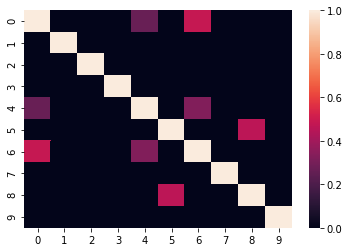

Key:
0 In the face of great perils never before encountered , our strong purpose is to protect and to perpetuate the integrity of democracy .
1 It is not in despair that I paint you that picture .
2 But it is not enough to achieve these purposes alone .
3 I see millions denied education , recreation , and the opportunity to better their lot and the lot of their children .
4 In such a spirit on my part and on yours we face our common difficulties .
5 Eight years ago , when the life of this Republic seemed frozen by a fatalistic terror , we proved that this is not true .
6 Many voices are heard as we face a great decision .
7 Shall we pause now and turn our back upon the road that lies ahead ?
8 True they have tried , but their efforts have been cast in the pattern of an outworn tradition .
9 In the field of world policy I would dedicate this Nation to the policy of the good neighbor  the neighbor who resolutely respects himself and , because he does so , respects the rights of others  t

In [114]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

## Tdidf on the original data for modeling



## All Addresses

In [122]:

#reading in the data, this time in the form of paragraphs
addresses=(inaugural.paras('1933-Roosevelt.txt') + inaugural.paras('1937-Roosevelt.txt') 
           + inaugural.paras('1941-Roosevelt.txt') + inaugural.paras('1945-Roosevelt.txt')
           + inaugural.paras('1949-Truman.txt') + inaugural.paras('1953-Eisenhower.txt')
           + inaugural.paras('1957-Eisenhower.txt') +inaugural.paras('1961-Kennedy.txt')
           + inaugural.paras('1965-Johnson.txt') + inaugural.paras('1969-Nixon.txt')
           + inaugural.paras('1973-Nixon.txt') + inaugural.paras('1977-Carter.txt')
           + inaugural.paras('1981-Reagan.txt') + inaugural.paras('1985-Reagan.txt')
           + inaugural.paras('1989-Bush.txt') + inaugural.paras('1993-Clinton.txt')
           + inaugural.paras('2001-Bush.txt') + inaugural.paras('2005-Bush.txt')
           + inaugural.paras('2009-Obama.txt'))


#processing
addresses_paras=[]
for paragraph in addresses:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    para=[re.sub('/\\n/g', "", word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    addresses_paras.append(' '.join(para))

print(addresses_paras[0:4])

['I am certain that my fellow Americans expect that on my induction into the Presidency I will address them with a candor and a decision which the present situation of our Nation impels .', 'In such a spirit on my part and on yours we face our common difficulties .', 'More important , a host of unemployed citizens face the grim problem of existence , and an equally great number toil with little return .', 'Yet our distress comes from no failure of substance .']


In [123]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(addresses_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
addresses_paras_tfidf=vectorizer.fit_transform(addresses_paras)
print("Number of features: %d" % addresses_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(addresses_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 961
Original sentence: In the long history of the world , only a few generations have been granted the role of defending freedom in its hour of maximum danger .
Tf_idf vector: {'hour': 0.3878788412259586, 'defending': 0.37060059416046487, 'granted': 0.3878788412259586, 'generations': 0.33698994973172713, 'role': 0.32189595118689734, 'danger': 0.33698994973172713, 'freedom': 0.22796324441158702, 'history': 0.2516212204217003, 'long': 0.2836983292474607, 'world': 0.18774592258811099}


In [124]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(120)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])



Percent variance captured by all components: 59.41483303212192
Component 0:
For the first time , because the people of the world want peace , and the leaders of the world are afraid of war , the times are on the side of peace .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        0.563445
My fellow citizens of the world : ask not what America will do for you , but what together we can do for the freedom of man .                                                                                                                       

Breakdown of components:

#### Component 0: 

Seems to be related to people of the world or something 'the world'. Also related to peace, freedom, and war. Authors of the sentences are as follows: Nixon (1st, R), Kennedy (D), Nixon (1st, R), Nixon (2nd, R), Nixon (2nd, R), George H. W. Bush (R), Raegan (2nd, R), Nixon (1st, R), Truman (D)

#### Component 1: 

Greetings and the start of the address. 

#### Component 2: 

Features America and quotes about America. 

#### Component 3: 

Government 

#### Component 4: 

Newness and greatness, as well as adventure and discovery

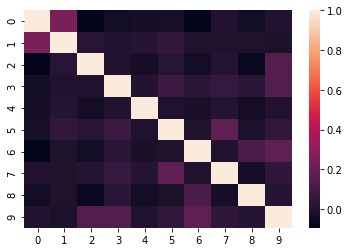

Key:
0 I have seen the hunger of a homeless child , the pain of a man wounded in battle , the grief of a mother who has lost her son .
1 We Americans of today , together with our allies , are passing through a period of supreme test .
2 I remember that my old schoolmaster , Dr . Peabody , said , in days that seemed to us then to be secure and untroubled : " Things in life will not always run smoothly .
3 To produce this unity , to meet the challenge of our time , destiny has laid upon our country the responsibility of the free world ' s leadership .
4 And whatever our views of its cause , we can agree that children at risk are not at fault .
5 In the long history of the world , only a few generations have been granted the role of defending freedom in its hour of maximum danger .
6 May we , in our dealings with all peoples of the earth , ever speak truth and serve justice .
7 The peace we seek in the world is not the flimsy peace which is merely an interlude between wars , but a peace w

In [125]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])